# Problem Set 5, due June 4 at 5:30 pm.

As usual, you are highly encouraged to *start this problem set early!*  My best guess (no guarantees!) is that Part 1 will be conceptually easy but perhaps time consuming.  Parts 2 and 3 are medium difficult, but there are plenty of opportunities to get confused with python data structures, so if you're going to get stuck, get stuck (and unstuck) early! Part 4 will give you an opportunity to get some intuition with PCA.

Note that the two extra credit problems have the potential to be quite challenging and time consuming. Make sure to do everything else in the problem set before you tackle the extra credit.

To get started, download the files "reviews.csv" and "movies.dat" from Canvas.

For this assignment, the following libraries may be useful:

* [numpy](http://docs.scipy.org/doc/numpy-dev/user/index.html), for arrays
* [scikit-learn](http://scikit-learn.org/stable/), for machine learning
* [pandas](http://pandas.pydata.org/), for data frames
* [matplotlib](http://matplotlib.org/), for plotting

In particular, I suggest you familiarize yourself with the following aspects of these libraries, which are not required but which might make your life easier:

* `DataFrame` and other basic [data structures](http://pandas.pydata.org/pandas-docs/stable/dsintro.html) in pandas
* [`groupby`](http://pandas.pydata.org/pandas-docs/stable/groupby.html), `unique`,  and other simple aggregation functions
* [`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) for working with text in sklearn.
* [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) for Naive Bayes
* Simple tools for [Cross-Validation](http://scikit-learn.org/stable/modules/cross_validation.html) in sklearn

Make sure they load properly with the following code block:

In [51]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#hint: Consult the scikit-learn documentation to
#   learn about what these classes do do
from  sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10

import string

from nltk.stem.porter import *
stemmer = PorterStemmer()

from nltk.corpus import stopwords

# Choose only english stop words
eng_SW = stopwords.words("english")

## Introduction to the assignment

In this assignment, you'll be analyzing movie reviews in an attempt to determine whether movies are good or bad.  I've downloaded a large number of movie reviews from the [Rotten Tomatoes](http://www.rottentomatoes.com) website, which are available in the file "reviews.csv" on Canvas.  I've also put a file "movies.dat" on Canvas that contains metadata for ~65,000 different movies

If you've never seen Rotten Tomatoes before, go spend a few minutes familiarizing yourself with the website.  It's a meta-review website that aggregates movie reviews from a large number of critics.  Here's what the page for this year's likely [Oscar winner](http://www.rottentomatoes.com/m/the_revenant_2015/) looks like.  Note in particular the section on "Critic Reviews" at the bottom -- that's the content that has been scraped and put in the reviews.csv file.  Also note that each movie is given a quantitative score on the Tomatometer which is used to classify the movie as either Fresh (good) or Rotten (bad).

Your mission is to develop a classifier to determine whether a movie is Fresh or Rotten based on the contents of the reviews given to the movie.  As usual, we'll start out with some exploratory data analysis.

---

## Part 1: Descriptive analysis

Before beginning the "real" work, dig into the data a bit do see what you're dealing with.  Begin by loading the datasets and dropping rows that have missing data:

In [2]:
reviews = pd.read_csv('reviews.csv')
movies = pd.read_csv("movies.dat", delimiter='\t')

# cleaning the data
reviews = reviews[~reviews.quote.isnull()]
reviews = reviews[reviews.fresh != 'none']
reviews = reviews[reviews.quote.str.len() > 0]

In [3]:
# number of null values in each column
movies.isnull().sum(axis = 0)

id                          0
title                       0
imdbID                      0
spanishTitle                0
imdbPictureURL            176
year                        0
rtID                      297
rtAllCriticsRating          0
rtAllCriticsNumReviews      0
rtAllCriticsNumFresh        0
rtAllCriticsNumRotten       0
rtAllCriticsScore           0
rtTopCriticsRating          0
rtTopCriticsNumReviews      0
rtTopCriticsNumFresh        0
rtTopCriticsNumRotten       0
rtTopCriticsScore           0
rtAudienceRating            0
rtAudienceNumRatings        0
rtAudienceScore             0
rtPictureURL                0
dtype: int64

We can observe here that there are 176 URLs and 297 rtIDs missing (NAs in the movies dataset)

In [4]:
reviews.isnull().sum(axis=0)

critic         701
fresh            0
imdb             0
link             0
publication      0
quote            0
review_date      0
rtid             0
title            0
dtype: int64

We can observe here that 701 critic names are missing in the reviews dataset

### 1.1: Basic features of the dataset

Answer the following questions by having your python code directly print the answers:

* How many unique reviews (quotes) are in the `reviews` dataset?
* How many unique reviewers (critics) are in the `reviews` dataset?
* How many unique movies are in the `reviews` dataset?
* How many unique movies are in the *`movies`* dataset?
* How many different publications have reviews in the `reviews` dataset?


In [5]:
# enter your code below

print("Number of reviews: %i" % len(reviews))

Number of reviews: 13419


In [6]:
# How many unique reviewers (critics) are in the reviews dataset?
print("Number of unique reviewers: %i" % len(reviews['critic'].unique()))

# How many unique movies are in the reviews dataset?
print("Number of unique movies: %i" % len(reviews['rtid'].unique()))

# How many unique movies are in the movies dataset?
print("Number of unique movies in the movies dataset: %i" %movies.shape[0])

# How many different publications have reviews in the reviews dataset?
print("Number of publications that have reviews: %i" %len(reviews['publication'].unique()))

Number of unique reviewers: 541
Number of unique movies: 1720
Number of unique movies in the movies dataset: 9423
Number of publications that have reviews: 64


### 1.2 Number of reviews per reviewer

Using the `reviews` dataset, create a histogram showing the distribution of the number of reviews per reviewer.  Create the bin width (x-axis) to be 1 unit wide, and the range of the axis to be from 0 to 30.  Scale the y-axis to show the logarithm of (count of) the number of reviews.  Label your axes and make your histogram look professional.

In [7]:
reviews_per_reviewer = pd.DataFrame(reviews.filter(['critic','quote']).groupby('critic').count().reset_index())

reviews_per_reviewer.head()

,critic,quote
0,A.D. Murphy,14
1,A.H. Weiler,17
2,A.O. Scott,10
3,Aaron Hillis,2
4,Abel Green,5


In [14]:
reviews_per_reviewer['quote'].max()

1150

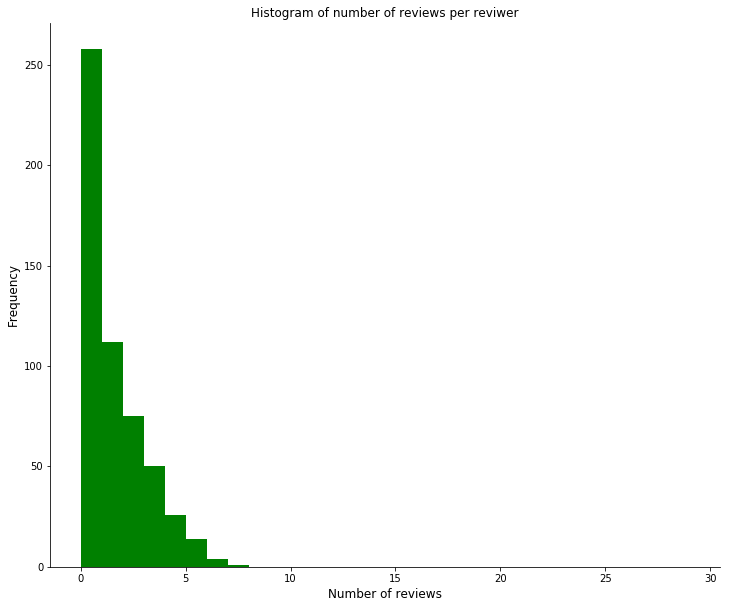

In [12]:
ax = plt.subplot(111)
ax.hist(np.log(reviews_per_reviewer.quote), color="green", lw=1, bins=range(0, 30, 1)) # setting bin width to $1000 and colour to green
plt.xlabel('Number of reviews', size = 12)
plt.ylabel('Frequency', size = 12)
plt.title('Histogram of number of reviews per reviwer')

# Remove the axes on the top and right side of the plot window
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

We can observe many reviewers have given no reviews

### 1.3 Zoom in on a few reviewers
Find the 30 critics with the most reviews, and list their names in a table along with (a) the name of the publication they work for, (b) the date of their first review, and (c) the date of their last review

*hint: use the groupby function to do this quickly*

In [26]:
df_sample.head()

,critic,publication,review_date
0,Derek Adams,Time Out,2009-10-04 00:00:00
1,Richard Corliss,TIME Magazine,2008-08-31 00:00:00
2,David Ansen,Newsweek,2008-08-18 00:00:00
3,Leonard Klady,Variety,2008-06-09 00:00:00
4,Jonathan Rosenbaum,Chicago Reader,2008-03-10 00:00:00


In [27]:
df_first_review = df_sample.groupby(['critic','publication']).min()
df_first_review.head()

review_date
critic       publication                           
A.D. Murphy  Variety            2001-02-13 00:00:00
A.H. Weiler  New York Times     2000-01-01 00:00:00
A.O. Scott   At the Movies      2009-11-30 00:00:00
             New York Times     2000-01-01 00:00:00
Aaron Hillis Time Out New York  2009-12-30 00:00:00

In [100]:
# filter required columns
top_critics = reviews_per_reviewer.filter(['critic','quote'], axis=1)
df_sample = reviews.filter(['critic','publication','review_date'], axis=1)

# get the first and last reviews in seperate dataframes
df_first_review = df_sample.groupby('critic').min()
df_last_review = df_sample.groupby('critic').max()

# merge first and last reviews into one dataframe
df_first_last_review = pd.merge(df_first_review,df_last_review, on = ['critic','publication'])
df_first_last_review = df_first_last_review.reset_index()

# rename the columns
df_first_last_review= df_first_last_review.rename(index=str, columns={"review_date_x": "review_date_first", "review_date_y": "review_date_last"})

# merge this with the top critics dataframe to get final result
df_merged_set = pd.merge(top_critics,df_first_last_review, on = ['critic'])

# print final table
print("TOP 30 CRITICS INFO:")
df_merged_set.sort_values(by='quote', ascending=False).head(30)

TOP 30 CRITICS INFO:


,critic,quote,publication,review_date_first,review_date_last
199,James Berardinelli,833,ReelViews,1800-01-01 00:00:00,2012-02-07 00:00:00
206,Janet Maslin,526,New York Times,2000-01-01 00:00:00,2010-09-07 00:00:00
481,Variety Staff,449,Variety,2001-02-13 00:00:00,2012-08-15 00:00:00
259,Jonathan Rosenbaum,420,Chicago Reader,1988-07-11 00:00:00,2013-10-22 00:00:00
130,Desson Thomson,373,Washington Post,2000-01-01 00:00:00,2012-10-08 00:00:00
177,Geoff Andrew,361,Time Out,2005-08-11 00:00:00,2012-04-05 00:00:00
279,Kenneth Turan,282,Los Angeles Times,2000-01-01 00:00:00,2013-10-05 00:00:00
340,Mick LaSalle,280,San Francisco Chronicle,2000-01-01 00:00:00,2009-11-25 00:00:00
362,Owen Gleiberman,241,Entertainment Weekly,1800-01-01 00:00:00,2011-09-07 00:00:00
400,Rita Kempley,236,Washington Post,2000-01-01 00:00:00,2013-11-02 00:00:00


### 1.4 Ratings over time

Using the `movies` dataset, create a plot that shows how the average rating per movie (rtAllCriticsRating) has evolved over time.  Do this by creating a scatterplot where the x-axis is the year in which the movie was released and the y-axis is rtAllCriticsRating.  Drop movies with 0 or unknown values to avoid biasing your results.  Then, create a scatterplot that has one <year,rating> point for each remaining movie, and pick an appropriate size/color/transparency for these points to ensure that the graph looks professional.  In other words, do not simply use the default settings, as this will produce a dense mess of dots that will be hard to interpret.  Finally, overlay on this scatterplot a line graph in orange showing how the average movie rating (the average of rtAllCriticsRating across all movies in a year) has changed over time.  Do you notice a trend?  What do you think it means?

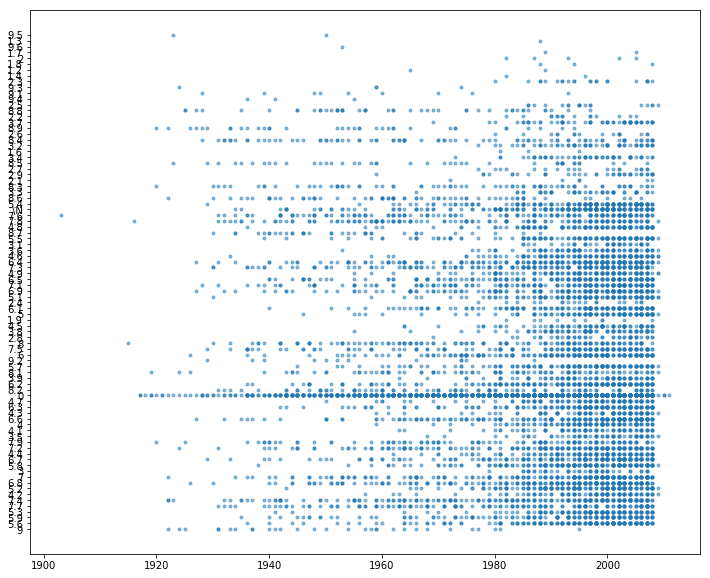

In [184]:
df_ratings_over_time = movies[movies['rtAllCriticsRating']!=0]

plt.plot(df_ratings_over_time['year'],df_ratings_over_time['rtAllCriticsRating'], '.', alpha=0.5)

*enter your observations here*

---

## Part 2: Naive Bayes

Now it gets fun!  You are going to use a [Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) to build a prediction model for whether a review is fresh or rotten, depending on the text of the review. Review the assigned readings on Canvas, as well as the relevant lecture notes before embarking on this journey.

### Using CountVectorizer

One thing that may help you in the following problems is the [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) object in Scikit-learn.  This will help you convert your raw text fields into "bag of words" vectors, i.e. a data structure that tells you how many times a particular word appears in a blurb.  Here's a simple example, make sure you understand what's going on!

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['machine learning rocks', 'machine learning rules', 'rocks rocks rules']
print("Original text is\n", '\n'.join(text))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print()
print("Transformed text vector is \n", x)

# `get_feature_names` tracks which word is associated with each column of the transformed x
print()
print("Words for each feature:")
print(vectorizer.get_feature_names())

Original text is
 machine learning rocks
machine learning rules
rocks rocks rules

Transformed text vector is 
 [[1 1 1 0]
 [1 1 0 1]
 [0 0 2 1]]

Words for each feature:
['learning', 'machine', 'rocks', 'rules']


In [32]:
# remove punctuations, stopwords and then stem each word

def stem_message(message):
    
    # remove punctuation characters using list comprehension
    msg_no_punctuation = [char for char in message if char not in string.punctuation]
    msg_no_punctuation = "".join(msg_no_punctuation).split() # join each word and then split at spaces
    
    # remove stopwords and create new list of words
    msg_no_punctuation_no_stopwords = [word.lower() for word in msg_no_punctuation if word.lower() not in eng_SW]
    
    stemmed_word_list = [stemmer.stem(word) for word in msg_no_punctuation_no_stopwords]
    # print(stemmed_word_list)
    
    return stemmed_word_list

### 2.1 Create your X input and Y output

Using the `reviews` dataframe, compute a pair of numerical X, Y arrays where:
    
 * X is a `(nreview, nwords)` array. Each row corresponds to a bag-of-words representation for a single review. This will be the *input* to your model.
 * Y is a `nreview`-element 1/0 array, encoding whether a review is Fresh (1) or Rotten (0). This is the desired *output* from your model.
 
Make sure to remove items with no review text

In [34]:
# create flag column to identity rotten reviews. if rotten, value = 1, else value = 0
reviews['rotten'] = reviews['fresh'].map( {'fresh': 0, 'rotten': 1} ).astype(int)

# subset required columns
df_reviews_classify = reviews.filter(['quote','rotten'], axis=1)
df_reviews_classify.head(20)

,quote,rotten
0,"So ingenious in concept, design and execution ...",0
1,The year's most inventive comedy.,0
2,A winning animated feature that has something ...,0
3,The film sports a provocative and appealing st...,0
4,"An entertaining computer-generated, hyperreali...",0
5,"As Lion King did before it, Toy Story revived ...",0
6,The film will probably be more fully appreciat...,0
7,Children will enjoy a new take on the irresist...,0
8,Although its computer-generated imagery is imp...,0
9,The result is a visionary roller-coaster ride ...,0


In [35]:
# check for missing reviews
df_reviews_classify.isnull().sum()

quote     0
rotten    0
dtype: int64

Looks like there are no missing reviews.

In [66]:
"""
Function
--------
make_xy

Build a bag-of-words training set for the review data

Parameters
-----------
reviews : Pandas DataFrame
    The review data from above
    
vectorizer : CountVectorizer object (optional)
    A CountVectorizer object to use. If None,
    then create and fit a new CountVectorizer.
    Otherwise, re-fit the provided CountVectorizer
    using the reviews data
    
Returns
-------
X : numpy array (dims: nreview, nwords)
    Bag-of-words representation for each review.
Y : numpy array (dims: nreview)
    1/0 array. 1 = fresh review, 0 = rotten review

Examples
--------
X, Y = make_xy(reviews)
"""
def make_xy(review_df, vectorizer):
    # vectorizer = CountVectorizer(analyzer=stem_message)
    
    # call `fit` to build the vocabulary
    document_term_matrix = vectorizer.fit(review_df['quote'])
    
    # print(len(document_term_matrix.vocabulary_))

    # call `transform` to convert text to a bag of words
    X = vectorizer.transform(review_df['quote'])
    
    # convert the flag column into an array and return it
    Y = review_df['rotten']
    Y = Y.values
    
    return X, Y

In [69]:
vectorizer = CountVectorizer(analyzer=stem_message)
X, Y = make_xy(df_reviews_classify, vectorizer)

### 2.2 Test-Train split

Next, randomly split the data into two groups: a training set and a validation set.  You can do this manually, as you did in the prior problem set.  Or, use [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html) to do this auto-magically.  See [this guide](http://scikit-learn.org/stable/modules/cross_validation.html) for a simple example of how `train_test_split` works.

In [38]:
# randomly split the dataset into train and test with 67% of the data in the training set and 33% in the test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=5)


### 2.3 Naive Bayes with `MultinomialNB`
Use the training set to train a Naive Bayes classifier using the [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)
 object.  Report the accuracy of this model on both the training and testing data.  What do you observe?  Interpret these results!

*Hint: This shouldn't take more than 5-10 lines of code to accomplish*



In [39]:
# enter your code here

# call the fitted model fitted_model, for future reference:
fitted_model = MultinomialNB().fit(X_train, y_train)


# predit for training data
y_pred_train = fitted_model.predict(X_train)

# Calculate the accuracy for training
acc_train = accuracy_score(y_train, y_pred_train)

print("Accuracy on training data = ",acc_train*100,"%")


# predit for test data
y_pred_test = fitted_model.predict(X_test)

# Calculate the accuracy for training
acc_test = accuracy_score(y_test, y_pred_test)

print("Accuracy on test data = ",acc_test*100,"%")

Accuracy on training data =  91.21245828698554 %
Accuracy on test data =  76.45066606457439 %


We can see that the model isnt doing that well with the test data. We need to fine tune it by finding th ebest value for the min_df and alpha by using criss validation. The accuracy is higher than the test in the training data (this is expected as we used the asme data to fit the model).

### 2.4 (EXTRA CREDIT) Naive Bayes from Scratch!
That was almost too easy, right?  Right.

Your next mission, should you choose to accept it, is to write your own Naive Bayes classifier without relying on `MultinomialNB` or a similar pre-written package.  In addition to the lecture notes and assigned readings, I highly recommend that you review Michael Collin’s lecture notes on Naïve Bayes before starting (available on Canvas).  

**Note:**
You should do this extra credit assignment *after* you have finished the rest of the problem set.  It is very rewarding, but can also be quite time-consuming!

*Hint: You will benefit most from this exercise if you attempt to write the algorithm directly from the lecture notes.  That said, if you really get stuck, Krishnamurthy Viswanathan has written a simple version of [NB in python](http://ebiquity.umbc.edu/blogger/2010/12/07/naive-bayes-classifier-in-50-lines/), which you can peek at if you really get stuck.*

In [ ]:
# Your code here

---

## Part 3: Evaluation

### 3.1 Estimate the likelihood of your data

Given a fitted model, you can compute the log-likelihood of your data as a way to assess the performance of your model.  Using `fitted_model.predict_logproba`, the idea is to write a function that computes the log-likelihood of a dataset, so that we can inspect the log-likelihood of your training and testing data given your fitted model from part 2.

To help you out a little bit, we'll do this part for you. But make sure you understand it, because you'll need to use this later!

In [46]:
"""
Function
--------
log_likelihood

Compute the log likelihood of a dataset according to a bayesian classifier. 
The Log Likelihood is defined by

L = Sum_fresh(logP(fresh)) + Sum_rotten(logP(rotten))

Where Sum_fresh indicates a sum over all fresh reviews, 
and Sum_rotten indicates a sum over rotten reviews
    
Parameters
----------
model : Bayesian classifier
x : (nexample, nfeature) array
    The input data
y : (nexample) integer array
    Whether each review is Fresh
"""

def log_likelihood(model, x, y):
    prob = model.predict_log_proba(x)
    rotten = y == 1
    fresh = ~rotten
    return prob[rotten, 1].sum() + prob[fresh, 0].sum()

# output the likelihood of your test data (example - you may need to 
# chance the nambes of the variables below to match your code in 2.2 and 2.3
    log_likelihood(fitted_model, X_test, y_test)

-2442.9301254896136

### 3.2 Cross-Validation

Why do we care about the log-likelihood of our data?  You guessed it: Cross-Validation.

Our classifier has a few hyperparameters. The two most important are:

 1. The `min_df` keyword in `CountVectorizer`, which will ignore words which appear in fewer than `min_df` fraction of reviews. Words that appear only once or twice can lead to overfitting, since words which occur only a few times might correlate very well with Fresh/Rotten reviews by chance in the training dataset.
 
 2. The [`alpha` keyword](http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) in the Bayesian classifier is a "smoothing parameter" -- increasing the value decreases the sensitivity to any single feature, and tends to pull prediction probabilities closer to 50%. 

How are we are going to use cross-validation to tune these hyperparameters?  The objective function we want to maximize is the log-likelihood of our data.  Fill in the remaining code in this block, to loop over many values of `alpha` and `min_df` to determine
which settings are "best" in the sense of maximizing the cross-validated log-likelihood.

*hint: sklearn has a built-in function, `sklearn.cross_validation.cross_val_score`, that might save you a lot of time here...*

In [71]:
#the grid of parameters to search over
alphas = [0, 0.1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
max_loglike = -np.inf

for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(analyzer=stem_message, min_df = min_df)       
        X, Y = make_xy(df_reviews_classify, vectorizer)
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=5)
        fitted_model = MultinomialNB(alpha = alpha)
        score = cross_val_score(fitted_model, X_train, y_train, scoring = log_likelihood, cv=KFold(n_splits=5))
        mean_score = score.mean()
        
        if(mean_score>max_loglike):
            max_loglike = mean_score
            best_alpha = alpha
            best_min_df = min_df

            
print("Best score =", max_loglike)
print("Best alpha =", best_alpha)
print("Best min_df =", best_min_df)

C:\Users\ashwi\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\ashwi\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\ashwi\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\ashwi\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\ashwi\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\ashwi\Anaconda3\lib\s

Best score = -963.6986569211122
Best alpha = 5
Best min_df = 0.001


### 3.3 Putting it together

Now that you've determined values for alpha and min_df that optimize the cross-validated log-likelihood, repeat the steps in 2.1-2.3 to train a final classifier with these parameters and re-evaluate the accuracy.  Discuss the various ways in which Cross-Validation has affected the model. Is the new model more or less accurate? Is overfitting better or worse?

In [72]:
vectorizer = CountVectorizer(analyzer=stem_message, min_df=0.001)
X, Y = make_xy(df_reviews_classify, vectorizer)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=5)
fitted_model = MultinomialNB(alpha = 5).fit(X_train, y_train)


# predit for training data
y_pred_train = fitted_model.predict(X_train)

# Calculate the accuracy for training
acc_train = accuracy_score(y_train, y_pred_train)

print("Accuracy on training data = ",acc_train*100,"%")


# predit for test data
y_pred_test = fitted_model.predict(X_test)

# Calculate the accuracy for training
acc_test = accuracy_score(y_test, y_pred_test)

print("Accuracy on test data = ",acc_test*100,"%")

Accuracy on training data =  79.55506117908787 %
Accuracy on test data =  74.48634003160984 %


Cross validation was used to find the best values for alpha and min_df. The training error decreased considerably (from 91% to 79.5%). This means that overfitting is reduced and the model is more generalized. The test accuracy did not change much (about 75%). Looks like this model is performing better.

### 3.4 (Extra Credit)

What happens if you tried this again using a function besides the log-likelihood -- for example, the classification accuracy?  Interpret these results

*enter your observations here*

### 3.5 Interpretation

What words best predict a fresh or rotten review?  Using your classifier and the `vectorizer.get_feature_names` method, determine which words best predict a positive or negative review. Print the 10 words that best predict a "fresh" review, and the 10 words that best predict a "rotten" review. For each word, what is the model's probability of freshness if the word appears one time?

#### Hints
* In thinking about how to measure the impact of a word on freshness rating, consider computing the classification probability for a feature vector which consists of all 0s, except for a single 1. What does this probability refer to?
* `numpy.identity` generates an identity matrix, where all values are zero except the diagonal elements which have a value of one

In [81]:
# Enter your code here

features = pd.DataFrame(np.array(vectorizer.get_feature_names()))
features.rename(columns={0:'words'}, inplace =True)

# Initialize identity matrix
imat = np.identity(np.shape(features)[0])
prob = fitted_model.predict_log_proba(imat)

features['rotten_prob'] = prob[:,1]
features['fresh_prob'] = prob[:,0]


print ('Best predictors for rotten reviews: \n', features.sort_values('rotten_prob', ascending=False)[['words', 'rotten_prob']].head(10))
print ('\n Best predictors for fresh reviews: \n', features.sort_values('fresh_prob', ascending=False)[['words', 'fresh_prob']].head(10))


Best predictors for rotten reviews: 
           words  rotten_prob
1846   unfortun    -0.136773
510        dull    -0.194716
967        lame    -0.218556
1847    unfunni    -0.227862
1284  pointless    -0.237998
173       bland    -0.237998
1849   uninspir    -0.261259
1461      sadli    -0.289593
1783    tiresom    -0.289593
1288       poor    -0.321613

 Best predictors for fresh reviews: 
            words  fresh_prob
441      delight   -0.101048
1064  masterpiec   -0.116939
1246     perfect   -0.129127
148       beauti   -0.137065
1953       witti   -0.138035
1679        stun   -0.156286
963      kubrick   -0.158188
766     greatest   -0.159645
1274     pleasur   -0.160797
818       highli   -0.170651


### Bar plots for top 10 words 

Text(0, 0.5, 'Word')

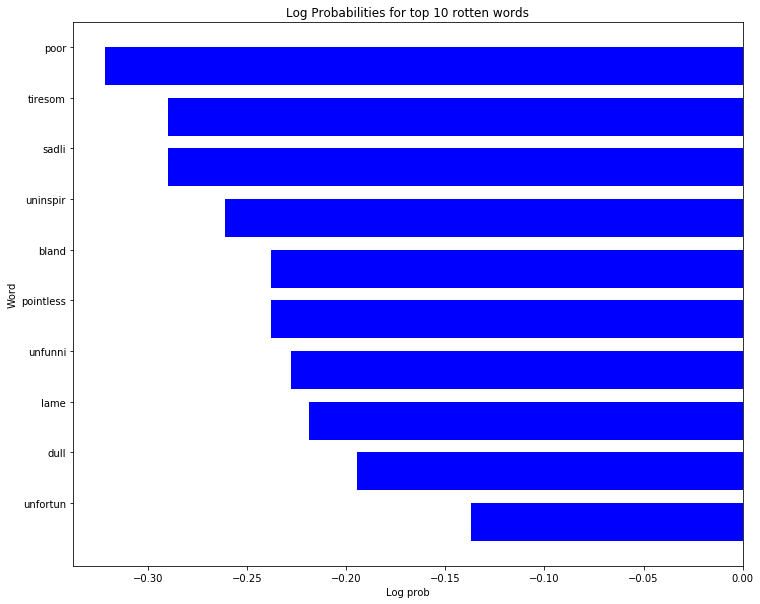

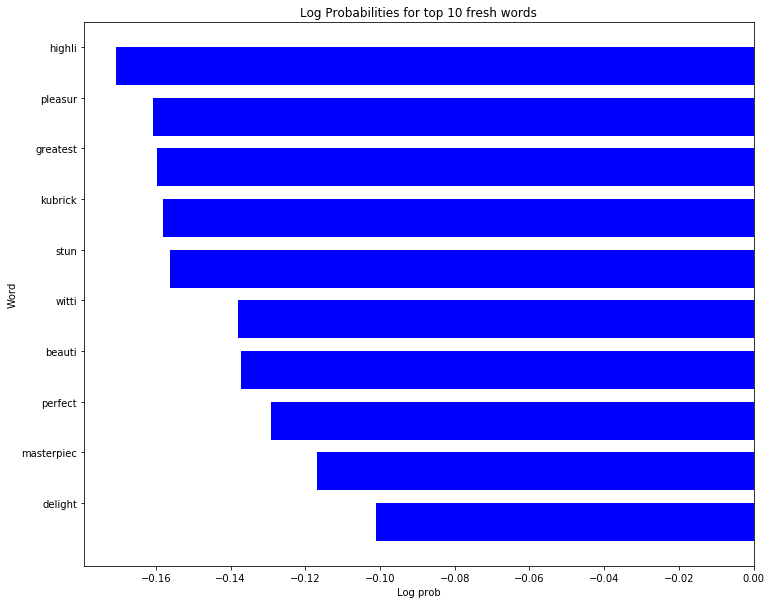

In [94]:
top_rotten = features.sort_values('rotten_prob', ascending=False)[['words', 'rotten_prob']].head(10)
top_fresh = features.sort_values('fresh_prob', ascending=False)[['words', 'fresh_prob']].head(10)

# Bar plot for rotten
x = top_rotten['words']
y = top_rotten['rotten_prob']

fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind, y, width, color="blue")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
plt.title('Log Probabilities for top 10 rotten words')
plt.xlabel('Log prob')
plt.ylabel('Word')


# bar plot for fresh words
x = top_fresh['words']
y = top_fresh['fresh_prob']

fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind, y, width, color="blue")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
plt.title('Log Probabilities for top 10 fresh words')
plt.xlabel('Log prob')
plt.ylabel('Word')


#### **Since these are log values (they are -ve), the actual highest value is the one with the lowest bar size. So we need to interpret this bar plot from bottom to top (in the y-axis). Also, the words are stemmed.

### 3.6 Error Analysis

One of the best sources for inspiration when trying to improve a model is to look at examples where the model performs poorly.  Find 5 fresh and rotten reviews where your model performs particularly poorly. Print each review.

What do you notice about these mis-predictions? Naive Bayes classifiers assume that every word affects the probability independently of other words. In what way is this a bad assumption? In your answer, report your classifier's Freshness probability for the review "This movie is not remarkable, touching, or superb in any way".

In [110]:
# Perform Naive Bayes on the whole dataset
vectorizer = CountVectorizer(analyzer = stem_message).fit(df_reviews_classify['quote'])
doc_term_matrix = vectorizer.transform(df_reviews_classify['quote'])
spam_detect_model = MultinomialNB().fit(doc_term_matrix, df_reviews_classify['rotten'].values)
y_pred = spam_detect_model.predict(doc_term_matrix)

In [111]:
# Check accuracy of the model on the training data itself
acc = accuracy_score(df_reviews_classify['rotten'].values, y_pred)
acc

0.9008122810939713

In [120]:
df_reviews_classify['predicted_rotten'] = y_pred

# calculate misclassified reviews
df_reviews_classify['missclassified'] = np.abs(df_reviews_classify['rotten'] - df_reviews_classify['predicted_rotten'])

df_reviews_classify.head()

,quote,rotten,predicted_rotten,missclassified
0,"So ingenious in concept, design and execution ...",0,0,0
1,The year's most inventive comedy.,0,0,0
2,A winning animated feature that has something ...,0,0,0
3,The film sports a provocative and appealing st...,0,0,0
4,"An entertaining computer-generated, hyperreali...",0,0,0


#### Top 5 misclassified reviews

In [125]:
pd.options.display.max_colwidth = 140
df_reviews_classify[df_reviews_classify['missclassified']==1]['quote'].head(5)

16                                        A gloomy special-effects extravaganza filled with grotesque images, generating fear and despair.
19                                      Just don't expect their bickering to be on the level of Neil Simon, and you won't be disappointed.
22                                              If you poke through Grumpy's cheap sentimentality, you'll find a worthy picture somewhere.
28                                                                       With one possible exception, none of its women is at all likable.
92    Nielsen makes a dapper and calmly inept Dracula, but it's Brooks' irrepressible and oblivious Van Helsing who's the main attraction.
Name: quote, dtype: object

##### We observe that in the reviews, words that occur in the reviews are actually not fully independant of each other. This goes against the assumption of Naive Bayes. For eg. the words "special effects" (in the first review) are not completely indepedant of each other. Most often they will occus together. Another example is "who's the" (in the last review) are also not fully independant. This is why its a bad assumption.

In [129]:
# Running the prediction for the sample imput provided in the question
test_input = "This movie is not remarkable, touching, or superb in any way"
transformed = vectorizer.transform([test_input])
spam_detect_model.predict(transformed)

array([0])

##### Again here can observe that out model is misclassifying this as a fresh review, even though it most probably is a rotten review. This is because of the words in the review. Most of the words in the review like (remarkable, touch and superb) are usually associated with fresh reviews. But because we are using 1-gram bag of words model and classifying, we are not able to classify this correctly. For improving the accuracy, we can use 2 gram BOW model or higher. This will be able to detect the difference betweem "is" and "is not".

## Part 4: Principal Component Analysis

Just when you thought you were *finally* done with the [Boston Housing Prices Data Set](http://archive.ics.uci.edu/ml/datasets/Housing), it has come back to haunt you for a few more minutes.  Make sure you're up and running as you were on the previous problem set:

### 4.1 Remember the last problem set?

Use matplotlib to create a scatter plot that shows the relationship between the median value of the home (y-axis) and the per-capita crime rate (x-axis).  Properly label your axes, and make sure that your graphic looks polished and professional.  If you didn't get full credit for this on the first problem set, get full credit this time!

Then, just as you did on the previous problem set, use the [Linear Regression class](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) from sklearn or the [OLS class](http://wiki.scipy.org/Cookbook/OLS) from SciPy to regress median housing price on average number of rooms per house.  Use a training set consisting of 66% of your instances to fit your regression model.  Report the RMSE on the training and test set.

In [130]:
from sklearn.decomposition import PCA
from sklearn.datasets import load_boston
bdata = load_boston()

In [131]:
# Preparing dataset
bos = pd.DataFrame(bdata.data)
bos.columns = bdata.feature_names
bos['PRICE'] = bdata.target
bos.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [132]:
# Split data into test and train
X = bos.filter(['RM'])
Y = bos.filter(['PRICE'])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=5)

In [133]:
# Applying Linear Regression
from sklearn.linear_model import LinearRegression

linreg = LinearRegression(normalize=True)
linreg.fit(X_train,y_train)

# predict for values in training set
y_pred_train = linreg.predict(X_train)
rmse_train = (np.sqrt(mean_squared_error(y_train, y_pred_train)))
print("The RMSE for training set is: ",rmse_train)

# predict for values in test set
y_pred_test = linreg.predict(X_test)
rmse_test = (np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("The RMSE for training set is: ",rmse_test)

The RMSE for training set is:  6.516055829068322
The RMSE for training set is:  6.789141476418063


### 4.2 So many scatterplots!

Choose 8 out of the 14 features of the housing data that you think are most interesting to study.  Create an 8x8 grid of scatterplots showing how each of these variables relate to each other.  You want to produce something that looks generally like [this image](http://iogas.net/wp-content/gallery/iogas-evaluation/scatterplot-matrix-point-density.png).

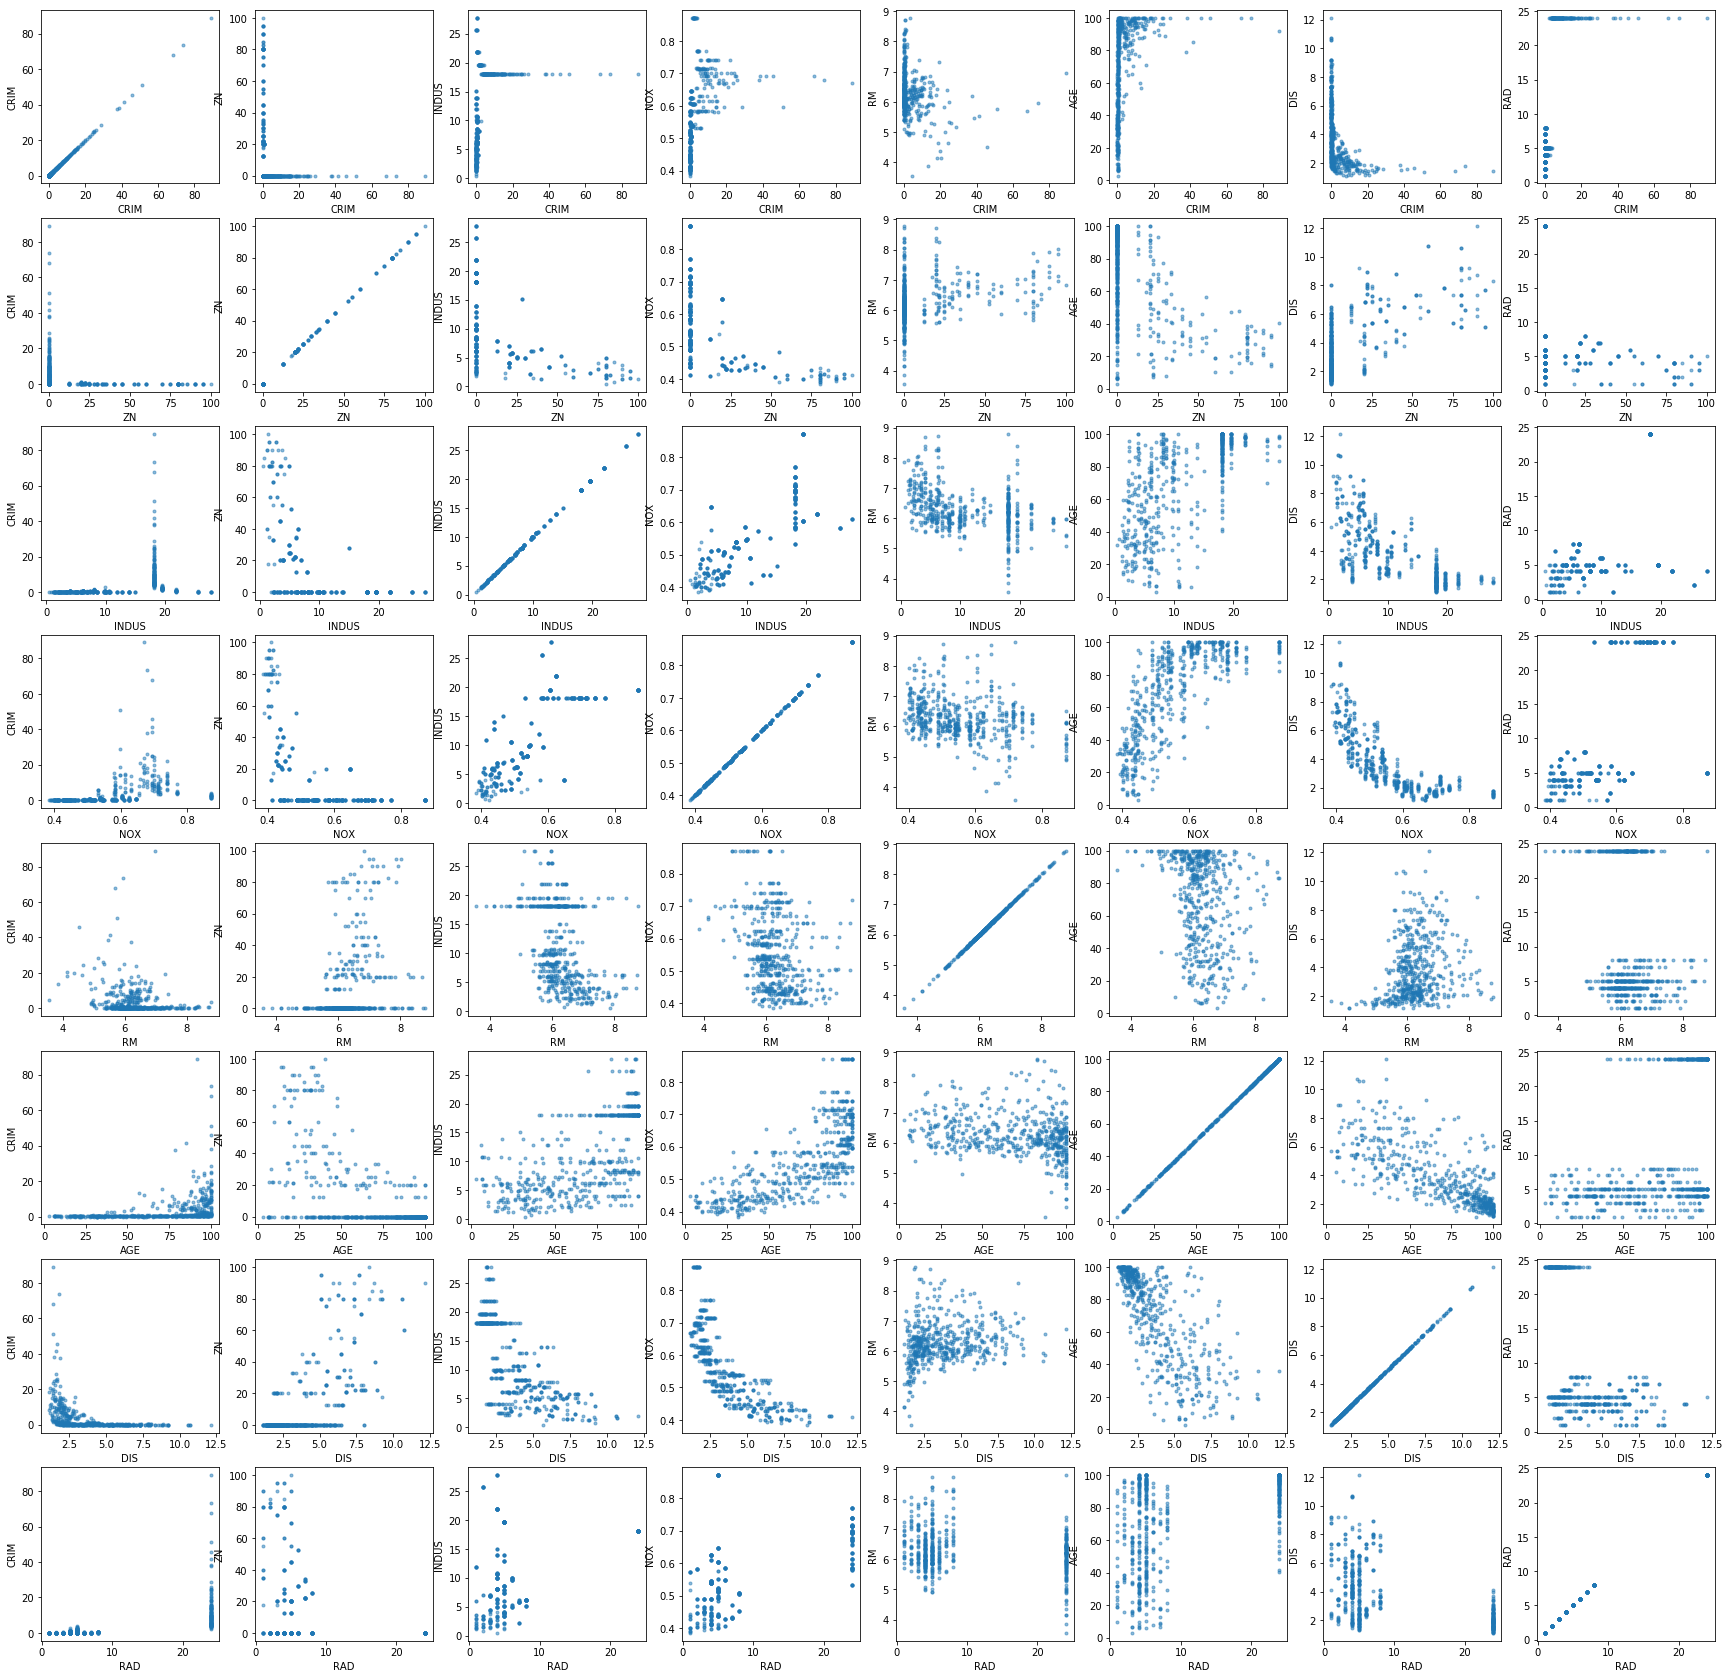

In [146]:
plt.figure(figsize=(30,30))
columns = ['CRIM','ZN','INDUS','NOX','RM','AGE','DIS','RAD']

for i in range(0,8):
    for j in range(0,8):
        plt.subplot(8, 8, i * 8 + j + 1)
        plt.plot(bos[columns[i]],bos[columns[j]], '.', alpha=0.5)
        plt.xlabel(columns[i])
        plt.ylabel(columns[j])
        

### 4.3 PCA to the rescue

Run principal component analysis using [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) from sklearn to find the first 12 principal components of your data.  Use only your training set (66% of the data), and use all features *except* the median housing price.  Create a figure showing how the amount of variance explained by your components increases as you increase the number of components from 1 to 12.

In [154]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# seperate data into X and Y
features = ['CRIM','ZN','INDUS','NOX','RM','AGE','DIS','RAD','CHAS','TAX','PTRATIO','B','LSTAT']
X = bos.loc[:, features].values
Y = bos.loc[:,['PRICE']].values

# Normalize the features - IMPORTANT FOR PCA!!!!!!!
X = StandardScaler().fit_transform(X)

# Splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.34, random_state=5)

In [181]:
# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Calculate variance for each iteration
nComponents = [i for i in range(1,13)]
variance = []
for i in range(1,13):
    pca = PCA(n_components=i)
    principalComponents = pca.fit_transform(X_train)
    variance.append(pca.explained_variance_ratio_.sum())

Text(0.5, 1.0, 'Variance vs Number of Components - PCA')

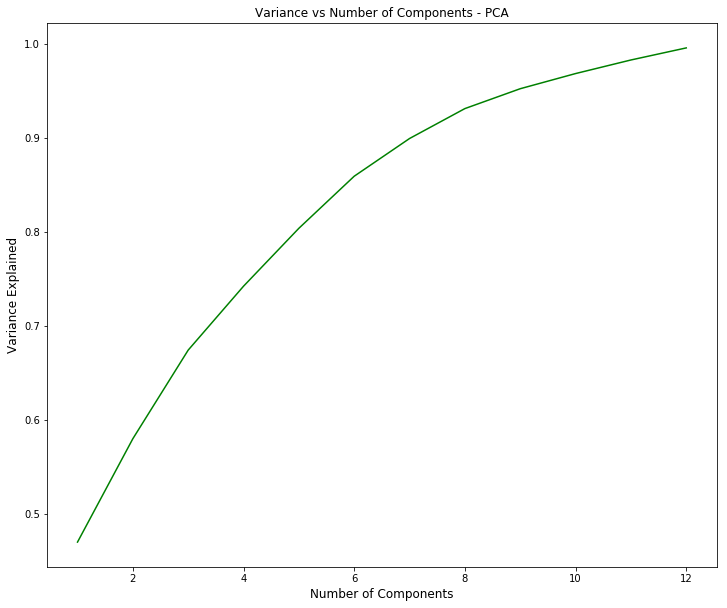

In [182]:
# plot the data
ax = plt.subplot(111)
ax.plot(nComponents,variance, color="green")
plt.xlabel('Number of Components', size = 12)
plt.ylabel('Variance Explained', size = 12)
plt.title('Variance vs Number of Components - PCA')

##### We can observe here that the variance is better explained as we add more number of components

### 4.4 Visualizing the components

Create a 1X3 grid containing three scatter plots of your training data:

1. PCA 1 vs. PCA 2 (you will need to use `fit_transform` to project your training data onto these two components)
2. PCA 1 (x-axis) vs. median housing value
3. PCA 2 vs. median housing value

In [183]:
# Apply PCA on the data with 2 components
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(X_train)

principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

principalDf['target'] = y_train

principalDf.head()

,PC1,PC2,target
0,-1.385121,0.189873,21.7
1,3.841733,-1.332021,8.4
2,1.876311,3.667215,15.3
3,-0.953855,-0.377297,20.3
4,-2.526372,-0.221748,32.0


In [202]:
pca.explained_variance_ratio_

array([0.47054621, 0.10983516])

Here, we can observe that PCA1 is responsible for about 47% of the variation and PC2 is responsible for about 11%

Text(0, 0.5, 'Median Price')

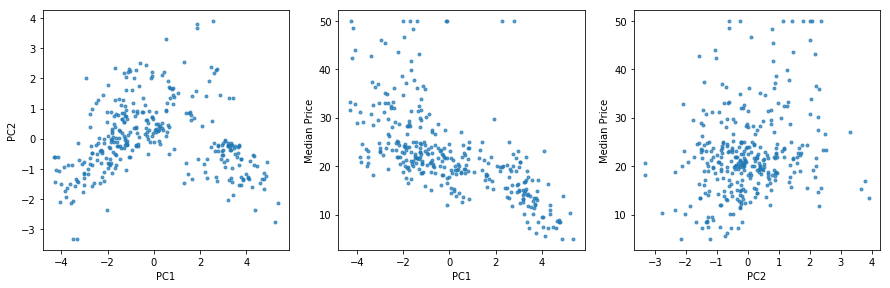

In [201]:
plt.figure(figsize=(15,15))
# first subplot
plt.subplot(3,3,1)
plt.plot(principalDf['PC1'],principalDf['PC2'],'.', alpha = 0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')

# Second subplot
plt.subplot(3,3,2)
plt.plot(principalDf['PC1'],principalDf['target'],'.', alpha = 0.7)
plt.xlabel('PC1')
plt.ylabel('Median Price')

# third subplot
plt.subplot(3,3,3)
plt.plot(principalDf['PC2'],principalDf['target'],'.', alpha = 0.7)
plt.xlabel('PC2')
plt.ylabel('Median Price')

In subplot 2, we can observe that as PC1 increases, the median prices decreases. We are able to see a visible pattern. 
But in subplot 3, we cannot really observe any pattern. This is because PC1 explains about 50% of the variance whereas PC2 only explains 11%. 

### 4.5 Regression and PCA

Using just the first Principal Component learned on the training data, project all of your data (including the test data) onto this 1-dimensional subspace using the `fit_transform` function.  Now, using your training data, fit a regression of median housing price on this first principal component of your data.  Report the RMSE of this regression for both the training and test set.  How do these results compare to your results from 4.1?  Interpret your results!

In [212]:
# Apply PCA on the data with 1 components
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(X)

new_X = principalComponents
pca.explained_variance_ratio_

array([0.47129606])

We can observe here that one 1 principal component only accounts to about 47% of the variation in the median price.

In [211]:
# Splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(new_X, Y, test_size=0.34, random_state=5)

# apply Linear regression
linreg = LinearRegression(normalize=True)
linreg.fit(X_train,y_train)

# predict for values in training set
y_pred_train = linreg.predict(X_train)
rmse_train = (np.sqrt(mean_squared_error(y_train, y_pred_train)))
print("The RMSE for training set is: ",rmse_train)

# predict for values in test set
y_pred_test = linreg.predict(X_test)
rmse_test = (np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("The RMSE for test set is: ",rmse_test)

The RMSE for training set is:  6.873851891772447
The RMSE for test set is:  7.989474309630741


We can observe here that the RMSE for both train and test have increased, only slightly for training but significantly for the test set (old training RMSE=6.51605 and old test RMSE = 6.78914). This is probably because of using too few components (only one in this case). As seen above, one principal component only accounts to about 47% of the variation in the median house prices. A lot of the information about the variance is not captured as there are too few principal components. We are trying to project the data in 13 dimensions, onto a single line. This will result in the loss of considerable information (53% of the variation is lost). So to get better accuracy, we need to increase the number of components.